(64, 640, 99)
(99, 64, 640)
(1, 1)


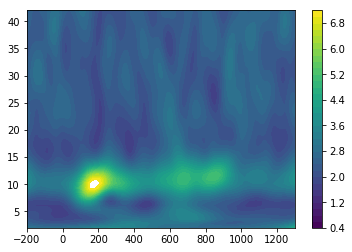

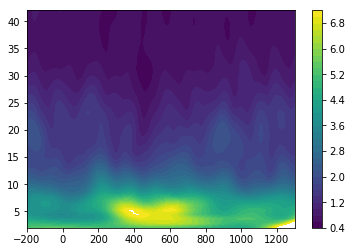

In [168]:
### import scipy.io as spio
import numpy as np
import scipy
import mne
import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import pandas as pd
from scipy import fft, ifft, arange
from statsmodels.tsa.api import VAR, DynamicVAR
from matplotlib.ticker import MaxNLocator
import matplotlib.colors as colors

a = spio.loadmat('sampleEEGdata.mat')
mat = a["EEG"]["data"]
print(mat[0,0].shape)
data = np.transpose(mat[0,0], (2,0,1))
print(data.shape)

# signal1 = mne.read_epochs('/home/robertofelipe_sg/Documents/Python/P04_Bsl_preprocessed_epo.fif')
#                           #P22_TACS_preprocessed_epo.fif')

# # Get data as a numpy array --> trials x channels x time-points
# data1 = signal1['stim_cor'].get_data()
# print(data1.shape)

# Retrieve channels of interest 
chan2use = ['o1', 'fz']
ch_index = np.array([[26], [37]])
channels = a['EEG']['chanlocs']
print(channels.shape)
#  = np.empty((len(chan2use),1), dtype=int)
# # i = 0
# # for idx, chan in enumerate(channels):
# #     if chan in chan2use:
# #         ch_index[i,0] = int(idx)
# #         i=i+1

# Frequency Parameters
min_freq = 2
max_freq = 42
num_freq = 50
frex = np.linspace(min_freq, max_freq, num_freq)

min_t = -1000
max_t = 1500
num_t = 640
timex = np.linspace(min_t, max_t, num_t)


# Baseline
baseline_window = np.array([-0.3, -0.1]);

# Baseline time into indices
baseidx1 = int(((baseline_window[0]+1.5)*data.shape[2])/3)
baseidx2 = int(((baseline_window[1]+1.5)*data.shape[2])/3)

# Parameters Morlet Wavelet
cyc_rng = np.array([3, 10])
srate = 250
timew = arange(-2,2,1/srate)
s = (np.logspace(np.log10(cyc_rng[0]), np.log10(cyc_rng[1]), num_freq)) / (2*np.pi*frex)
half_w = (len(timew)/2) +1
half_w = int(half_w)

# Initialize output Time-Frequency
tifr = np.empty((len(ch_index),len(frex), data.shape[2]))
fase = np.empty((len(frex), data.shape[2]), dtype=complex)
itpc = np.empty((len(frex), data.shape[2]))
tifrx = np.empty((len(ch_index), len(frex), data.shape[2]), dtype=int)
ispcx = np.empty((len(ch_index), data.shape[2], len(frex)), dtype=complex)
itpcx = np.empty((len(ch_index), data.shape[2], len(frex)))
mean_tf = np.empty((len(frex), data.shape[2]))
mean_ph = np.empty((len(frex), data.shape[2]), dtype=complex)
mean_itpc = np.empty((len(frex), data.shape[2]))
nData = data.shape[0] * data.shape[2] #* len(ch_index)
nConv = len(timew) + nData - 1

# Looping over channels
for ch in range(ch_index.shape[0]):

    # FFT on all trials concatenated
    alldata = np.reshape(data[:,ch_index[ch,0],:], (1,nData))
    datax = fft(alldata, nConv)

    # Looping over Frequencies
    for idx, f in enumerate(frex):

        # Create best wavelet according to frequency of analysis (best resolution)
        wavelet = (np.exp(2j*np.pi*f*timew)) * (np.exp((-timew**2)/(2*s[idx]**2)))
        wavex = fft(wavelet, nConv)
        wavex = wavex / max(wavex)

        # Applying convolution in the Freq.Domain
        convo = ifft(datax*wavex)
        convo = convo[0, half_w-1 : len(convo)-half_w+1]

        # Reshape into trials x time
        convo = np.reshape(convo, (data.shape[0], data.shape[2]) )

        # Computing power and averaging over all trials
        tifr[ch,idx,:] = np.mean(abs(convo)**2, axis=0)

        # Phase-Angle (Angle & Magnitude) for every freq + Averaged over trials
        fase[idx,:] = np.mean(np.exp(1j*np.angle(convo)),0) # --> frex x time-points  

        # Compute ITPC --> Avg. accross trials
        itpc[idx,:] = abs(np.mean(np.exp(1j*(np.angle(convo))),0))
        
    # Plotting Spectrum
    fig1 = plt.figure()
    levels = MaxNLocator(nbins=40).tick_values(0.5, 7.2)#tick_values(G1_avg.min(), G1_avg.max())
    #ax = fig1.add_subplot(3,1,ch+1)
    # CS = plt.contourf(a['EEG']['times'][0,0], frex, tifrx[1,:,:], 40)
    CS = plt.contourf(timex, frex, tifr[ch,:,:], 40, levels=levels)#, norm=colors.Normalize(vmin=0, vmax=5))
    cbar = fig1.colorbar(CS)
    plt.xlim(-200,1300)

#     # Power every channel and Decibel Normalization 
#     tifrx[ch,:,:] = (10*np.log10([tifr[:,i] / (np.mean(tifr[:,baseidx1:baseidx2],1)) for i in range(data.shape[2])])).T

#     # Angle every channel and Normalization
#     ispcx[ch,:,:] = ([fase[:,i] / (np.mean(fase[:,baseidx1:baseidx2],1)) for i in range(data.shape[2])]) 

#     # Phase Coh / Conservation every channel and Normalization
#     itpcx[ch,:,:] = ([itpc[:,i] / (np.mean(itpc[:,baseidx1:baseidx2],1)) for i in range(data.shape[2])])

 # Power Average over channels
mean_tf[:,:] = np.mean(tifrx, axis=0)

# Phase Average over channels
mean_ph[:,:] = (np.mean(ispcx, axis=0)).T    

# ITPC Average over channels
mean_itpc[:,:] = (np.mean(itpcx, axis=0)).T 
    


#ax.set_title('%s' %chan2use[ch])
    
# # Phase Difference
# ph_diff = phase_data[1,:,:,:] - phase_data[0,:,:,:]
# ispc_freq = abs((np.mean(np.exp(1j*ph_diff),1)))# frex x trials x time-points
# ispc_alpha = np.angle(np.mean(np.mean(np.exp(1j*ph_diff),1)[5:11],0))
# ispc_gamma = np.angle(np.mean(np.mean(np.exp(1j*ph_diff),1)[28:40],0))
# ispc_time = abs(np.mean(np.mean(np.exp(1j*ph_diff),1),0))
# ispc_tri = abs(np.mean(np.mean(np.exp(1j*ph_diff[:,:,372:378]),2),0))
# ispc_ang_tr = np.angle(np.mean(np.mean(np.exp(1j*ph_diff[:,:,372:378]),2),0))

# #scipy.io.savemat('areg.mat', {'electrodes':areg})

# fig2 = plt.figure()
# ax1 = fig2.add_subplot(1,2,1)
# stdev = np.std(ispc_time)
# plt.plot(signal1.times[50:700], ispc_time[50:700])
# plt.fill_between(signal1.times[50:700], ispc_time[50:700]+stdev, ispc_time[50:700]-stdev,alpha=.1)
# #ax1.plot(frex, ispc_freq)
# plt.tick_params(labelsize=20)
# plt.ylabel('ISPC', fontsize=20)
# plt.xlabel('Time(s)', fontsize=20)
# plt.ylim(0,0.5)
# ax2 = fig2.add_subplot(1,2,2, projection='polar')

# phase=np.empty([2,data.shape[0]])
# magni=np.empty([2,data.shape[0]])
# for c,_ in enumerate(ispc_tri):
#     phase[:,c]=np.array([0, ispc_ang_tr[c]])
#     magni[:,c]=np.array([0, ispc_tri[c]])
# colors = magni
# plt.scatter(phase,magni,c=colors, marker='o')

# fig3 = plt.figure()
# plt.plot(signal1.times[50:700], ispc_alpha[50:700])
# plt.plot(signal1.times[50:700], ispc_gamma[50:700])
# plt.ylim(2*np.pi,-2*np.pi)

# plt.show()


In [24]:
import numpy as np
G1_cf = np.empty([5,6,2,15])
for a in range(15):
    G1_cf[:,:,:,a] = np.load('../../../Documents/1st_2nd_Results/Sources/CrossFr_Src/Data/zPAC/Bsl/zPAC_V1V5_G3_Bsl_%s.npy' %(a+1))
    print(G1_cf[:,:,0,a])
G1_V1pV5a_avg = np.mean(G1_cf[:,:,0,:], axis=2)    
print("G1_V1pV5a_avg")
print(G1_V1pV5a_avg)

[[-0.53038649 -0.5054751  -0.5403908   0.4961919  -1.08505518 -0.79569457]
 [-0.3364182  -0.47370906 -0.11543499  0.6954717   0.41998332  0.00939578]
 [-0.34286594 -0.98207343  0.22824932  0.83011648  0.26056141 -0.12700386]
 [-0.22330809 -0.17988505  0.32110818  0.69586413 -0.62615564 -1.01691399]
 [ 0.59654969 -0.04386719  0.24123331  0.70205515 -1.27511162 -1.13684242]]
[[ 0.27275788  1.01642524  2.53534685  1.00297875  1.34038399  0.87615871]
 [ 0.486064    0.98752751  2.74371961  1.84407196  1.52582657  0.05882586]
 [ 0.95263481  1.78416394  3.19048557  2.24969455  1.15518453 -0.00650918]
 [ 1.10838037  2.39911198  2.75075327  1.85125265  0.85350813 -0.01096153]
 [ 1.10594374  2.5099905   2.4823847   1.63522836  0.45083175  0.23386131]]
[[ 0.17215885 -0.78621809 -1.70922998  0.32231067 -1.21775225 -0.31058179]
 [-0.91827304 -0.6101907  -1.21064844  0.33397984 -1.20385508 -1.1011414 ]
 [-1.4402513  -1.15223661 -0.43368231 -0.5223436  -1.01482512 -1.02489894]
 [-0.7249089  -1.103525

[[ 1.28167837e-02 -8.12588176e-03 -3.98040185e-02 ... -1.83254127e-02
  -1.85317897e-02 -1.90800475e-02]
 [ 2.11433601e-02 -2.97795695e-05 -3.58348171e-02 ... -1.56755472e-02
  -1.59242695e-02 -1.66834395e-02]
 [ 3.58019733e-02  1.52019294e-02 -2.59217779e-02 ... -1.35588120e-02
  -1.37190760e-02 -1.44415624e-02]
 ...
 [ 1.62163067e-02  7.49001379e-04 -2.11232585e-02 ...  3.95048699e-02
   4.02929247e-02  4.12456708e-02]
 [ 1.66606778e-02  7.34062969e-04 -2.17971794e-02 ...  3.99292066e-02
   4.07163030e-02  4.16645537e-02]
 [ 1.68329243e-02  5.47235453e-04 -2.25094897e-02 ...  4.02434342e-02
   4.10307883e-02  4.19763045e-02]]
(45, 45)
cluster_thresh 0.0
numb_label 35
[[-0.03505629 -0.02749377 -0.02678813 ... -0.01094494 -0.01109013
  -0.01169457]
 [-0.04094384 -0.02617547 -0.02202978 ... -0.00523791 -0.00546611
  -0.00621405]
 [-0.03285928 -0.01447238 -0.01588316 ...  0.00372658  0.0034065
   0.00256038]
 ...
 [ 0.0287584  -0.00333937 -0.03263808 ...  0.0407942   0.04183035
   0.0429

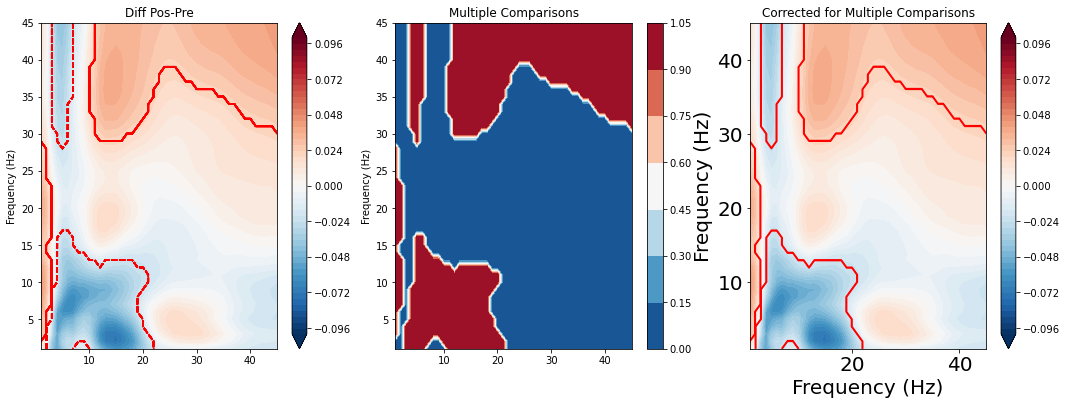

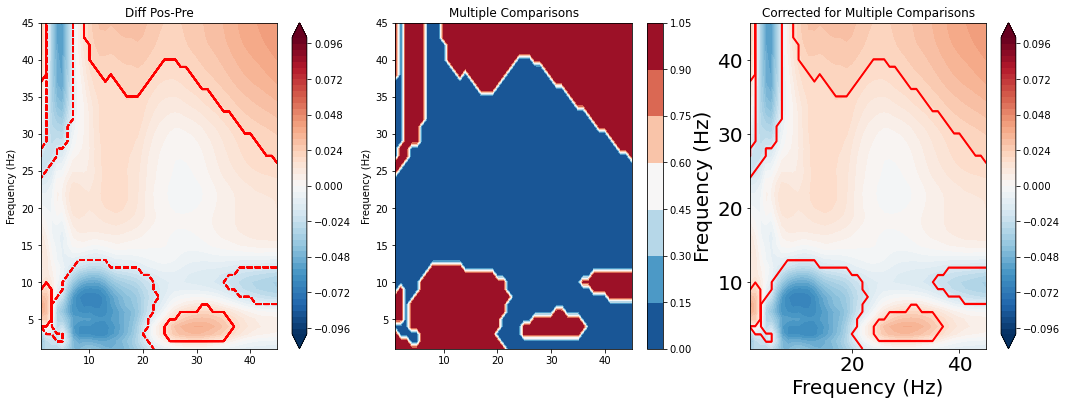

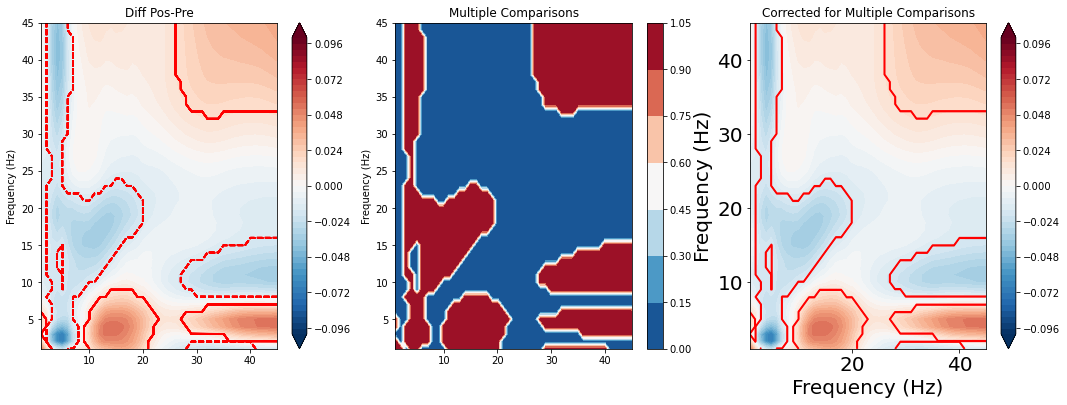

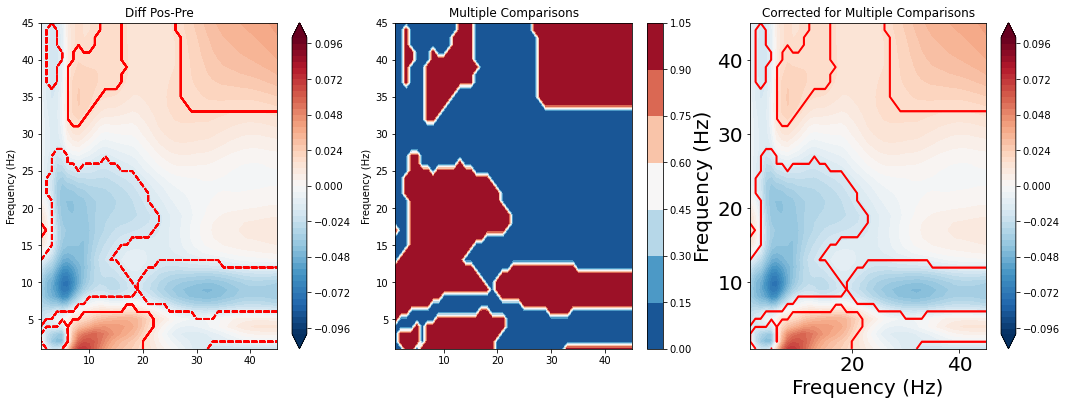

In [1]:
import scipy.io
import numpy as np
from Stats_CF import *
from scipy.sparse import csc_matrix

mat = scipy.io.loadmat('../../../Desktop/Ind_Perf_Mat.mat')
b = mat['IndPerf_BMat']
first  = np.empty([15,45,45])
second = np.empty([15,45,45])
third  = np.empty([15,45,45])
fourth = np.empty([15,45,45])
# print(b[:,0][0][0,0].shape)
for i in range(15):
    first[i,:,:] = csc_matrix(b[:,i][0][0,0], shape=(45, 45)).toarray()
    second[i,:,:] = csc_matrix(b[:,i][0][0,1], shape=(45, 45)).toarray()
    third[i,:,:] = csc_matrix(b[:,i][0][1,0], shape=(45, 45)).toarray()
    fourth[i,:,:] = csc_matrix(b[:,i][0][1,1], shape=(45, 45)).toarray()
    
# print(first[0,:,:])    
Stats_CF(first[:,:,:], first[:,:,:], 'CF_first')
Stats_CF(second[:,:,:], second[:,:,:], 'CF_second')
Stats_CF(third[:,:,:], third[:,:,:], 'CF_third')
Stats_CF(fourth[:,:,:], fourth[:,:,:], 'CF_fourth')

(3, 2)
[[-0.08856703 -0.0445883   0.01460116 ... -0.03250572 -0.03278369
  -0.03310159]
 [-0.0953505  -0.05942213 -0.00958427 ... -0.01426718 -0.01585194
  -0.01765204]
 [-0.06301274 -0.05108539 -0.04391236 ... -0.00659008 -0.00806114
  -0.00979689]
 ...
 [-0.01196111  0.01965532  0.03343556 ...  0.03551438  0.03337713
   0.03079923]
 [-0.00834918  0.02331822  0.03596024 ...  0.03268309  0.03062433
   0.02815044]
 [-0.00580965  0.02612662  0.03810341 ...  0.02953381  0.02758898
   0.0252526 ]]
(45, 45)
cluster_thresh 0.0
numb_label 54
[[ 0.01138992  0.07332623  0.10131657 ...  0.08128324  0.08336681
   0.08564172]
 [ 0.03163728  0.09428277  0.09695976 ...  0.065465    0.06619702
   0.06778832]
 [-0.00560014  0.05428425  0.05504992 ...  0.03984528  0.03885439
   0.03937123]
 ...
 [-0.06620263 -0.07646396 -0.0530393  ...  0.04132372  0.04065235
   0.04032735]
 [-0.06412671 -0.07720926 -0.05643301 ...  0.03750706  0.03671122
   0.03638817]
 [-0.06241698 -0.07742923 -0.05836891 ...  0.0350

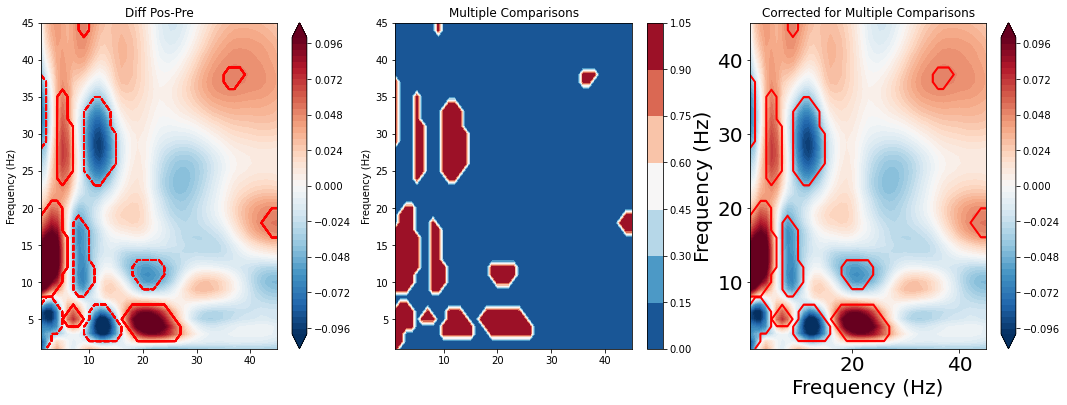

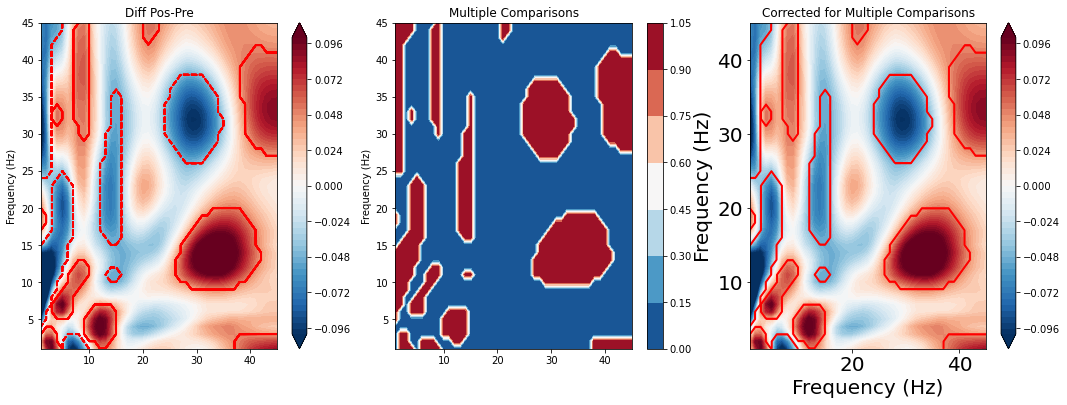

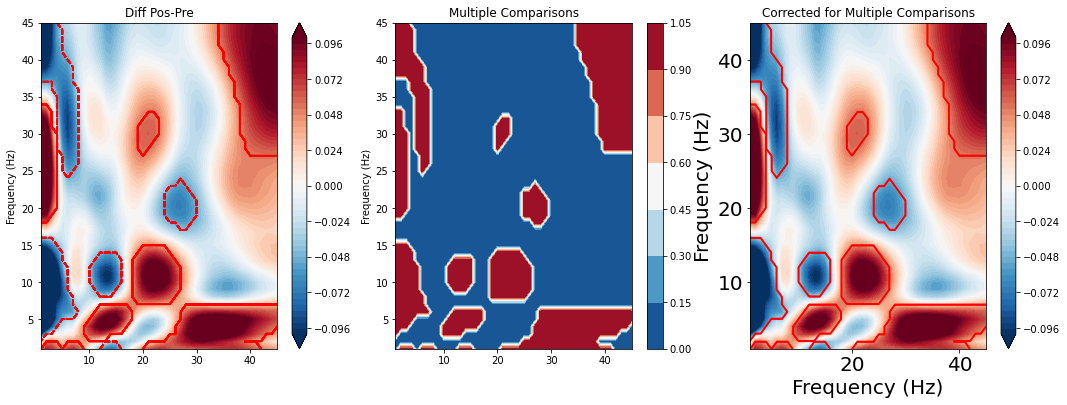

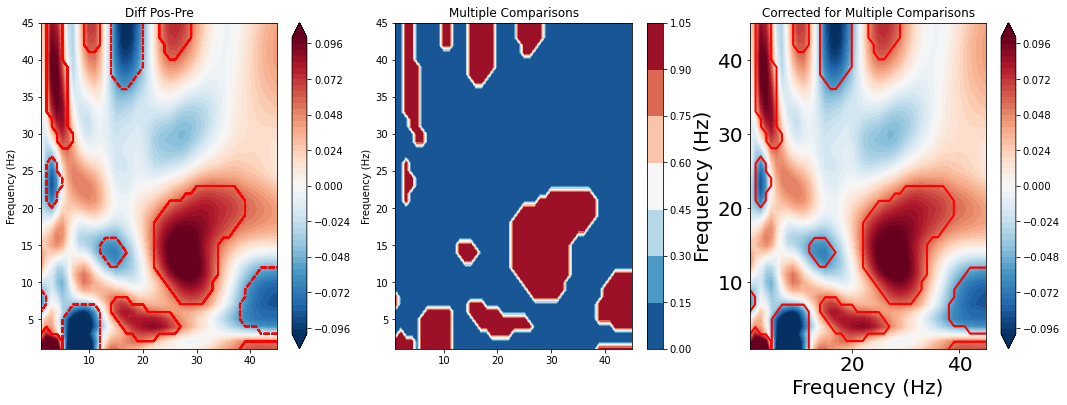

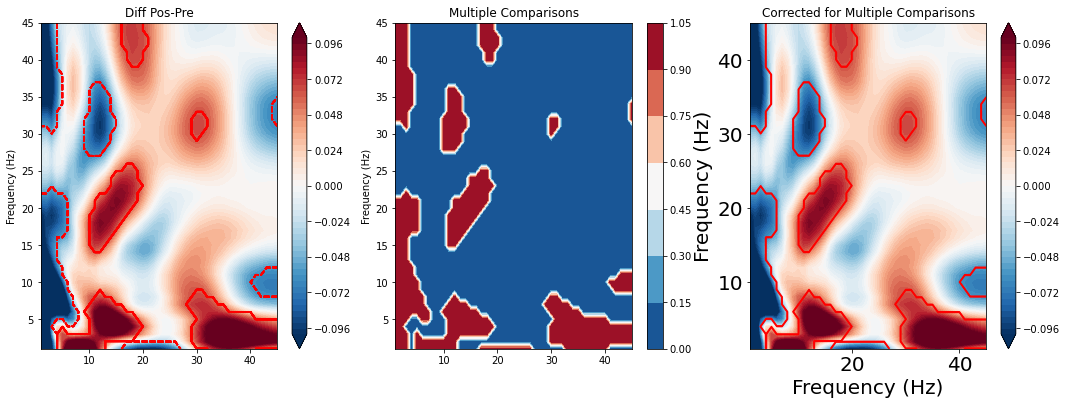

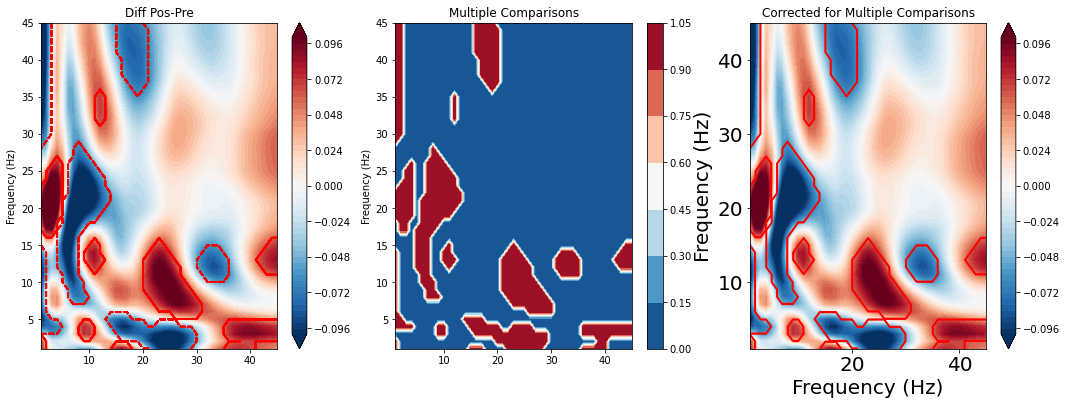

In [7]:
import scipy.io
import numpy as np
from Stats_CF import *
from scipy.sparse import csc_matrix

mat = scipy.io.loadmat('../../../Desktop/Ind_Coh_Mat.mat')
b = mat['IndCoh_BMat']
first  = np.empty([15,45,45])
second = np.empty([15,45,45])
third  = np.empty([15,45,45])
fourth = np.empty([15,45,45])
fifth = np.empty([15,45,45])
sixth = np.empty([15,45,45])
print(b[:,0][0].shape)
for i in range(15):
    first[i,:,:] = csc_matrix(b[:,i][0][0,0], shape=(45, 45)).toarray()
    second[i,:,:] = csc_matrix(b[:,i][0][1,0], shape=(45, 45)).toarray()
    third[i,:,:] = csc_matrix(b[:,i][0][2,0], shape=(45, 45)).toarray()
    fourth[i,:,:] = csc_matrix(b[:,i][0][0,1], shape=(45, 45)).toarray()
    fifth[i,:,:] = csc_matrix(b[:,i][0][1,1], shape=(45, 45)).toarray()
    sixth[i,:,:] = csc_matrix(b[:,i][0][2,1], shape=(45, 45)).toarray()
    
# print(first[0,:,:])    
Stats_CF(first[:,:,:], first[:,:,:], 'CF_first_coh')
Stats_CF(second[:,:,:], second[:,:,:], 'CF_second_coh')
Stats_CF(third[:,:,:], third[:,:,:], 'CF_third_coh')
Stats_CF(fourth[:,:,:], fourth[:,:,:], 'CF_fourth_coh')
Stats_CF(fifth[:,:,:], fifth[:,:,:], 'CF_fifth_coh')
Stats_CF(sixth[:,:,:], sixth[:,:,:], 'CF_sixth_coh')

In [68]:
import mne
import numpy as np
s1 = mne.read_epochs('/home/robertofelipe_sg/Documents/Preprocessed/Bursts/B_Fl1_preprocessed_epo.fif')
s2 = mne.read_epochs('/home/robertofelipe_sg/Documents/Preprocessed/Bursts/B_Fl2_preprocessed_epo.fif')
s1vc = s1['verum_cor'].get_data()
s2vc = s2['verum_cor'].get_data()
s1vi = s1['verum_inc'].get_data()
s2vi = s2['verum_inc'].get_data()
s1sc = s1['sham_cor'].get_data()
s2sc = s2['sham_cor'].get_data()
s1si = s1['sham_inc'].get_data()
s2si = s2['sham_inc'].get_data()
svc = numpy.concatenate((s1vc,s2vc),axis=0)
svi = numpy.concatenate((s1vi,s2vi),axis=0)
ssc = numpy.concatenate((s1sc,s2sc),axis=0)
ssi = numpy.concatenate((s1si,s2si),axis=0)
# print(svc.shape,svi.shape,ssc.shape,ssi.shape)
print(s1.info)
svce = numpy.concatenate((s1['verum_cor'].events,s2['verum_cor'].events),axis=0)
svie = numpy.concatenate((s1['verum_inc'].events,s2['verum_inc'].events),axis=0)
ssce = numpy.concatenate((s1['sham_cor'].events,s2['sham_cor'].events),axis=0)
ssie = numpy.concatenate((s1['sham_inc'].events,s2['sham_inc'].events),axis=0)
# print(s1['verum_cor'].events)
event_id = dict(verum_cor=184, verum_inc=186, sham_cor=284, sham_inc=286)
eps = mne.EpochsArray(np.concatenate((svc,svi,ssc,ssi)), s1.info, tmin=-1.5, events=np.concatenate((svce,svie,ssce,ssie)), event_id=event_id)
eps.save('Flo_preprocessed_epo.fif', overwrite=True)

Reading /home/robertofelipe_sg/Documents/Preprocessed/Bursts/B_Fl1_preprocessed_epo.fif ...
    Found the data of interest:
        t =   -1500.00 ...    2496.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
65 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Reading /home/robertofelipe_sg/Documents/Preprocessed/Bursts/B_Fl2_preprocessed_epo.fif ...
    Found the data of interest:
        t =   -1500.00 ...    2496.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
133 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
<Info | 11 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, T7, C3, C4, ...
 chs: 63 EEG
 custom_ref_applied: True
 dig: 63 items (63 EEG)
 file_id: 4 items (dict)
 highpass: 1.0 Hz
 lowpass: 105.0 Hz
 meas_date: 2021-03-02 14:58:41 UTC
 meas_id: 4 items (dict)


<ipython-input-68-8c9d5ef5472f>:25: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  eps = mne.EpochsArray(np.concatenate((svc,svi,ssc,ssi)), s1.info, tmin=-1.5, events=np.concatenate((svce,svie,ssce,ssie)), event_id=event_id)


In [46]:
events = np.column_stack((np.arange(0, 1000, 200),
                          np.zeros(5, dtype=int),
                          np.array([1, 2, 1, 2, 1])))
print(events)

[[  0   0   1]
 [200   0   2]
 [400   0   1]
 [600   0   2]
 [800   0   1]]
